In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [267]:
K=10
nbIt=5000

In [268]:
labels=[]

for i in range(5): 
    labels.append('représentation'+str(i))
for i in range(K):
    labels.append('taux de clics'+str(i))

In [270]:
X=pd.read_csv('http://dac.lip6.fr/master/wp-content/uploads/2019/06/CTR.txt', 
              sep=':|;', names=labels, engine='python')

tauxClics=X.loc[:,'taux de clics0':'taux de clics9']

In [271]:
tirages=np.random.randint(K,size=nbIt)

x1=np.zeros(nbIt)

for i in range(nbIt):
    x1[i]=tauxClics.iloc[i,tirages[i]]

x1=x1.cumsum()

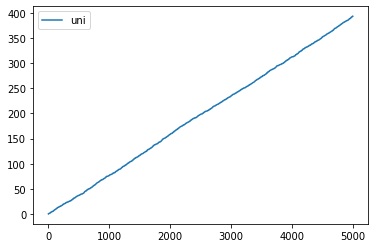

In [272]:
plt.plot(x1, label='uni')
plt.legend();

In [273]:
colMax=tauxClics.mean().idxmax()

x2=tauxClics.loc[:,colMax].cumsum()

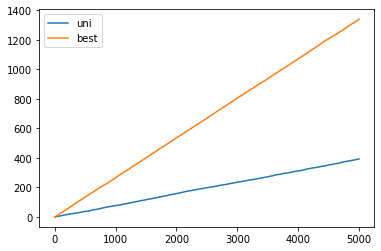

In [274]:
plt.plot(x1, label='uni')
plt.plot(x2, label='best')
plt.legend();

In [275]:
x3=tauxClics.max(axis=1).cumsum()

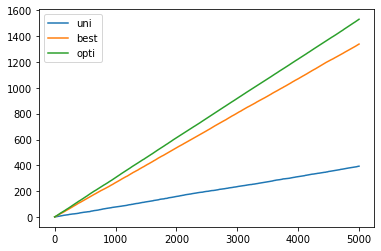

In [276]:
plt.plot(x1, label='uni')
plt.plot(x2, label='best')
plt.plot(x3, label='opti')
plt.legend();

In [277]:
#UCB 
EmpiricalMean=np.zeros(K)
EmpiricalMeanIteration=np.ones(K)
x4=[]

for i in range(nbIt):
    if i<K:
        x4.append(tauxClics.iloc[i,i])
        EmpiricalMean[i]=tauxClics.iloc[i,i]
    else: 
        Perturbation=np.sqrt(2*np.log(i)/EmpiricalMeanIteration)
        choix=np.argmax(EmpiricalMean+Perturbation)
        x4.append(tauxClics.iloc[i,choix])
        EmpiricalMeanIteration[choix]+=1
        EmpiricalMean[choix]=(EmpiricalMean[choix]*(EmpiricalMeanIteration[choix]-1)+tauxClics.iloc[i,choix])/EmpiricalMeanIteration[choix]

x4=np.cumsum(x4)

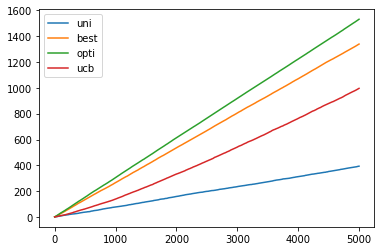

In [278]:
plt.plot(x1, label='uni')
plt.plot(x2, label='best')
plt.plot(x3, label='opti')
plt.plot(x4, label='ucb')
plt.legend();

In [279]:
class linucb_disjoint_arm():
    
    def __init__(self, arm_index, d, alpha):
        
        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)
        
        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        self.theta = np.dot(A_inv, self.b)
        
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector
        p = np.dot(self.theta.T,x) +  self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv,x)))
        
        return p
    
    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x, x.T)
        
        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x
    

In [284]:
alpha=1
bras=[]
for b in range(K):
    bras.append(linucb_disjoint_arm(b,5,alpha))
x5=[]
for t in range(nbIt):
    p=[]
    for b in range(K):
        p.append(bras[b].calc_UCB(np.array(X.iloc[t,:5])))
    a=np.argmax(p)
    x5.append(tauxClics.iloc[t,a])
    bras[a].reward_update(tauxClics.iloc[t,a], np.array(X.iloc[t,:5]))

x5=np.cumsum(x5);    

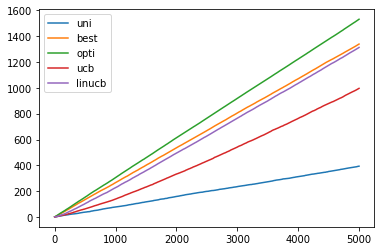

In [285]:
plt.plot(x1, label='uni')
plt.plot(x2, label='best')
plt.plot(x3, label='opti')
plt.plot(x4, label='ucb')
plt.plot(x5, label='linucb')
plt.legend();